# IMPACT Mania and Psychosis Screening

In [1]:
import datetime as dt
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import synapseclient
from synapseclient import Activity, File, Schema, Table, as_table_columns
from tqdm import tqdm
import numpy as np

InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

tqdm.pandas()

Welcome, Abhishek Pratap!



### Prep V2 data for public release

In [2]:
v2sid = 'syn9974018'
v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['createdAt'])
v2r.head()

,username,Did a doctor ever prescribe a medication called Lithium to you?,Were you prescribed any medication for having a period of being so excited or irritable that you got into trouble or your family or friends worried about it?,Did a doctor ever say you were manic-depressive or had bipolar disorder?,Did a doctor ever say that you have schizophrenia or a schizoaffective disorder or psychosis?,day,createdAt
0,EN05264,No,Yes,Yes,Yes,1,2016-12-11 07:20:04
1,EN00478,No,No,No,No,1,2016-11-11 07:22:25
2,EN00083,No,No,Yes,No,1,2016-08-31 22:58:22
3,EN00276,No,No,No,No,1,2016-09-07 22:23:40
4,ES05030,No,Yes,Yes,No,1,2016-11-10 18:10:39


In [3]:
v2r = v2r.rename(columns={
    'Did a doctor ever prescribe a medication called Lithium to you?':'screen_1',
    'Were you prescribed any medication for having a period of being so excited or irritable that you got into trouble or your family or friends worried about it?':'screen_2',
    'Did a doctor ever say you were manic-depressive or had bipolar disorder?':'screen_3',
    'Did a doctor ever say that you have schizophrenia or a schizoaffective disorder or psychosis?':'screen_4'
})

v2r.head()

,username,screen_1,screen_2,screen_3,screen_4,day,createdAt
0,EN05264,No,Yes,Yes,Yes,1,2016-12-11 07:20:04
1,EN00478,No,No,No,No,1,2016-11-11 07:22:25
2,EN00083,No,No,Yes,No,1,2016-08-31 22:58:22
3,EN00276,No,No,No,No,1,2016-09-07 22:23:40
4,ES05030,No,Yes,Yes,No,1,2016-11-10 18:10:39


<AxesSubplot:>

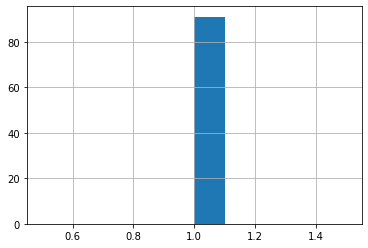

In [4]:
v2r.day.hist()

### Drop that meaningless column and upload to Synapse

In [5]:
# v2r = v2r.drop(columns=['day'])

# name = 'V2_MentalHealthScreen.csv'
# v2r.to_csv(name, index=None)

# t = syn.setProvenance(
#     syn.store(File(name=name, path=name, parent='syn10848316')),
#     activity=Activity(
#         name='Public Release',
#         description='Prep data for public release',
#         used=[v2sid],
#         executed=[
#             dict(
#                 name='IPython Notebook',
#                 url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Create_MHS_datafiles.ipynb'
#             )
#         ]
#     )
# ); del t

### Prep V1 and V2 for release

In [5]:
v1sid, v2sid = 'syn12204723', 'syn17023315'

v1r = pd.read_csv(syn.get(v1sid).path, parse_dates=['timestamp'])
v2r = pd.read_csv(syn.get(v2sid).path, parse_dates=['createdAt'])

v1r.head()
v2r.head()

,userid,brightenid,timestamp,timestampUTC,screen_1,screen_2,screen_3,screen_4
0,10431,BLUE-00048,2014-08-01 06:58:14,2014-08-01 10:58:15,No,No,No,No
1,10470,BLUE-00049,2014-08-01 12:29:06,2014-08-01 16:29:07,No,No,No,No
2,10519,BLUE-00050,2014-08-08 19:27:25,2014-08-09 02:27:25,No,Yes,Yes,No
3,10617,BLUE-00051,2014-08-05 13:33:22,2014-08-05 17:33:21,No,No,No,No
4,10672,BLUE-00052,2014-08-04 14:25:54,2014-08-04 21:25:55,No,No,No,No


,username,screen_1,screen_2,screen_3,screen_4,createdAt
0,EN05264,No,Yes,Yes,Yes,2016-12-11 07:20:04
1,EN00478,No,No,No,No,2016-11-11 07:22:25
2,EN00083,No,No,Yes,No,2016-08-31 22:58:22
3,EN00276,No,No,No,No,2016-09-07 22:23:40
4,ES05030,No,Yes,Yes,No,2016-11-10 18:10:39


#### Prep V1 data

In [6]:
v1 = v1r.drop(columns=[
    'userid', 'timestampUTC'
]).rename(columns={
    'brightenid':'participant_id',
    'timestamp':'dt_response'
})

def fx(x):
    if x == 'No':
        return 0
    elif x == 'Yes':
        return 1
    else:
        raise ValueError(f'encoding not mapped: {x}')

v1.screen_1 = v1.screen_1.apply(fx)
v1.screen_2 = v1.screen_2.apply(fx)
v1.screen_3 = v1.screen_3.apply(fx)
v1.screen_4 = v1.screen_4.apply(fx)
        
v1.head()

,participant_id,dt_response,screen_1,screen_2,screen_3,screen_4
0,BLUE-00048,2014-08-01 06:58:14,0,0,0,0
1,BLUE-00049,2014-08-01 12:29:06,0,0,0,0
2,BLUE-00050,2014-08-08 19:27:25,0,1,1,0
3,BLUE-00051,2014-08-05 13:33:22,0,0,0,0
4,BLUE-00052,2014-08-04 14:25:54,0,0,0,0


#### Prep V2 data

In [7]:
v2 = v2r.rename(columns={
    'username':'participant_id',
    'createdAt':'dt_response'
}).loc[:, ['participant_id', 'dt_response', 'screen_1', 'screen_2', 'screen_3', 'screen_4']]

v2.screen_1 = v2.screen_1.apply(fx)
v2.screen_2 = v2.screen_2.apply(fx)
v2.screen_3 = v2.screen_3.apply(fx)
v2.screen_4 = v2.screen_4.apply(fx)
        
v2.head()

,participant_id,dt_response,screen_1,screen_2,screen_3,screen_4
0,EN05264,2016-12-11 07:20:04,0,1,1,1
1,EN00478,2016-11-11 07:22:25,0,0,0,0
2,EN00083,2016-08-31 22:58:22,0,0,1,0
3,EN00276,2016-09-07 22:23:40,0,0,0,0
4,ES05030,2016-11-10 18:10:39,0,1,1,0


### Combine

In [8]:
combined = pd.concat([v1, v2], sort=False)
combined.head()
combined.size

,participant_id,dt_response,screen_1,screen_2,screen_3,screen_4
0,BLUE-00048,2014-08-01 06:58:14,0,0,0,0
1,BLUE-00049,2014-08-01 12:29:06,0,0,0,0
2,BLUE-00050,2014-08-08 19:27:25,0,1,1,0
3,BLUE-00051,2014-08-05 13:33:22,0,0,0,0
4,BLUE-00052,2014-08-04 14:25:54,0,0,0,0


4950

### Add week into study

In [10]:
metasid = 'syn27082597'
metadata = syn.tableQuery(f'SELECT participant_id, startdate FROM {metasid}').asDataFrame(convert_to_datetime=True)
metadata.startdate = pd.to_datetime(metadata.startdate)

# add in the participants start date as a new column
combined = pd.merge(combined, metadata, on='participant_id', how='left')

# get the time difference in weeks as a float
combined['week'] = [
    d.days/7 for d in (
        combined.dt_response.apply(
            lambda x: dt.datetime(year=x.year, month=x.month, day=x.day))-combined.startdate
    )
]

# convert the week number to an int by taking the floor
combined.week = combined.week.progress_apply(lambda x: np.int16(np.floor(x))+1)# if not pd.isnull(x) else np.nan)

# remove the start date
combined = combined.drop(columns=['startdate'], errors='ignore')

# reorder the columns
cols = list(combined.columns)
cols = cols[0:2] + ['week'] + cols[2:-1]
combined = combined.reindex(columns=cols)

combined.head()

100%|██████████| 825/825 [00:00<00:00, 107252.92it/s]


,participant_id,dt_response,week,screen_1,screen_2,screen_3,screen_4
0,BLUE-00048,2014-08-01 06:58:14,3,0,0,0,0
1,BLUE-00049,2014-08-01 12:29:06,1,0,0,0,0
2,BLUE-00050,2014-08-08 19:27:25,1,0,1,1,0
3,BLUE-00051,2014-08-05 13:33:22,1,0,0,0,0
4,BLUE-00052,2014-08-04 14:25:54,0,0,0,0,0


### Localize timestamps

In [11]:
# localize timestamps
combined['dt_response'] = [
    str(t.tz_localize('UTC'))
    for t in combined.dt_response
]

combined.head()

,participant_id,dt_response,week,screen_1,screen_2,screen_3,screen_4
0,BLUE-00048,2014-08-01 06:58:14+00:00,3,0,0,0,0
1,BLUE-00049,2014-08-01 12:29:06+00:00,1,0,0,0,0
2,BLUE-00050,2014-08-08 19:27:25+00:00,1,0,1,1,0
3,BLUE-00051,2014-08-05 13:33:22+00:00,1,0,0,0,0
4,BLUE-00052,2014-08-04 14:25:54+00:00,0,0,0,0,0


### Upload to Synapse

In [12]:
t = syn.delete(
    syn.tableQuery('select * from syn17023316')
)

In [13]:
final = syn.store(Table(
    Schema(
            name='IMPACT Mania and Psychosis Screening',
            columns=as_table_columns(combined), 
            parent='syn10848316'),
        combined
    )
)

In [17]:
final = syn.setProvenance(
    'syn27051276',
    activity=Activity(
        name='Combine V1 and V2 data for IMPACT Mania and Psychosis Screening',
        description='Process and combine the data collected during study 1 and study 2',
        used=[v1sid, v2sid],
        executed=[
            dict(
                name='Curate_IMPACT_Mania_and_PsychosisScreening_data',
                url='hCre'
            )
        ]
    )
)